In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, jaccard_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import os
from skimage.feature import graycomatrix, graycoprops

Размер данных: (810, 10)
Количество классов: 10


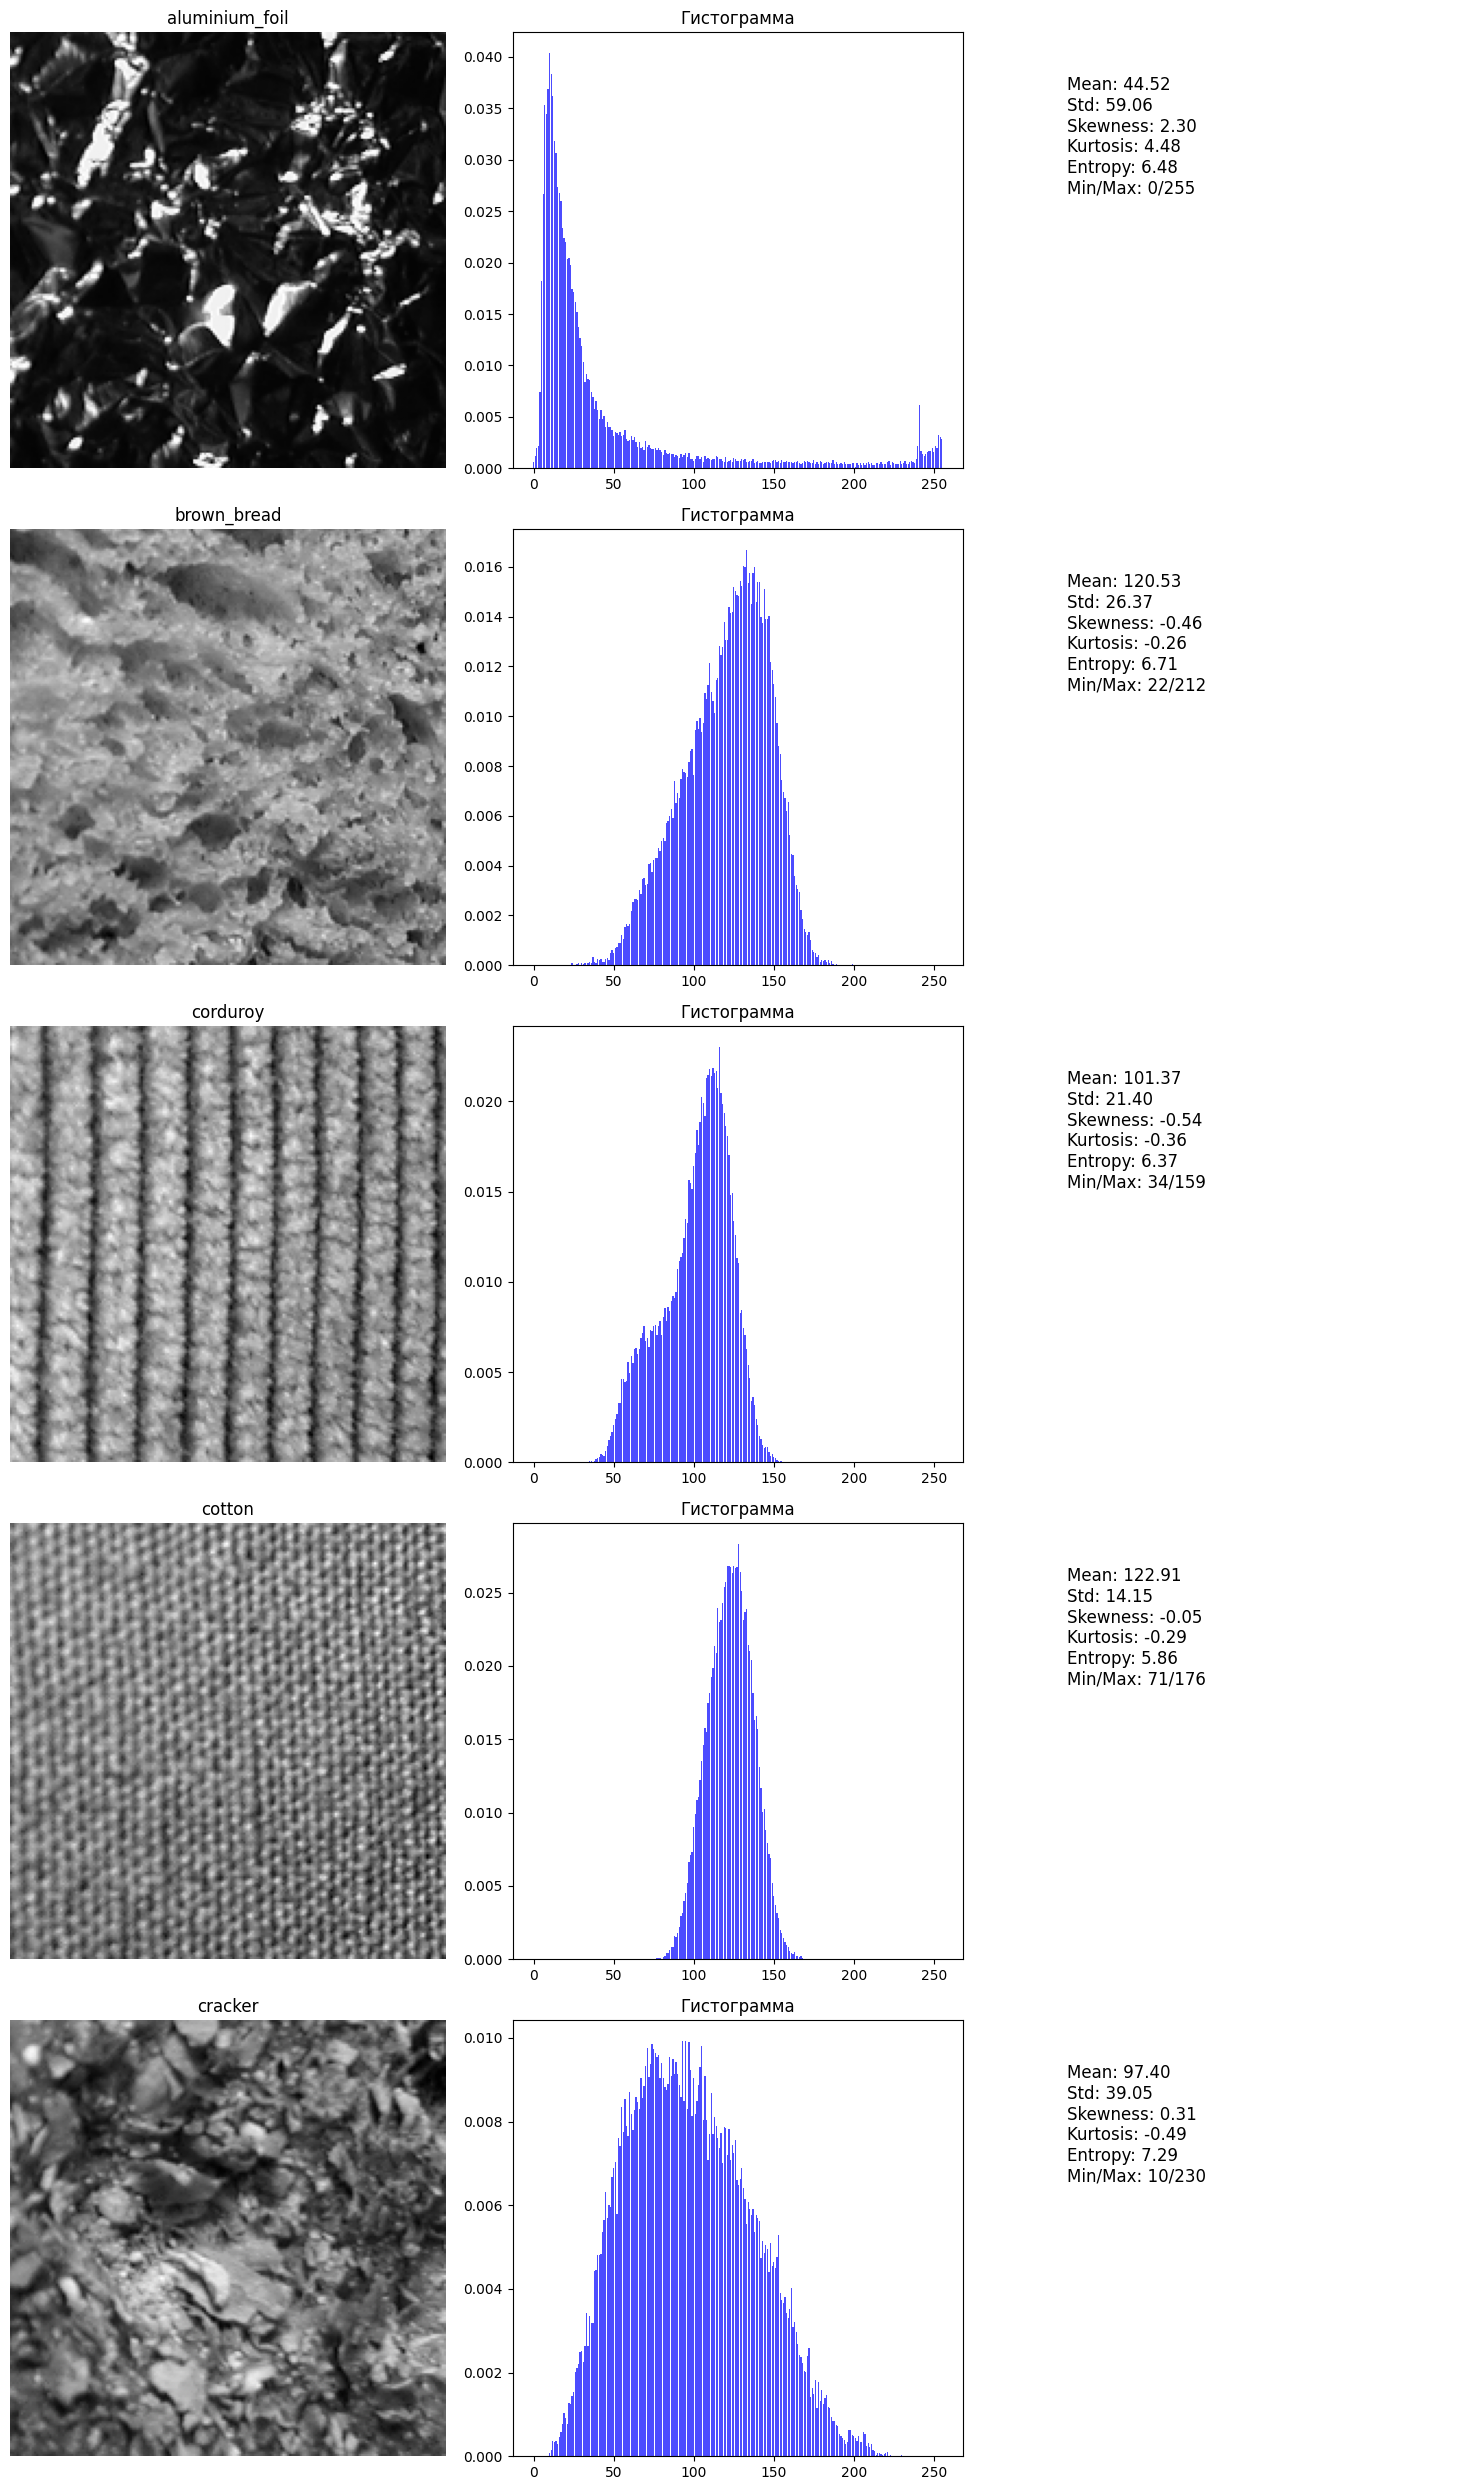

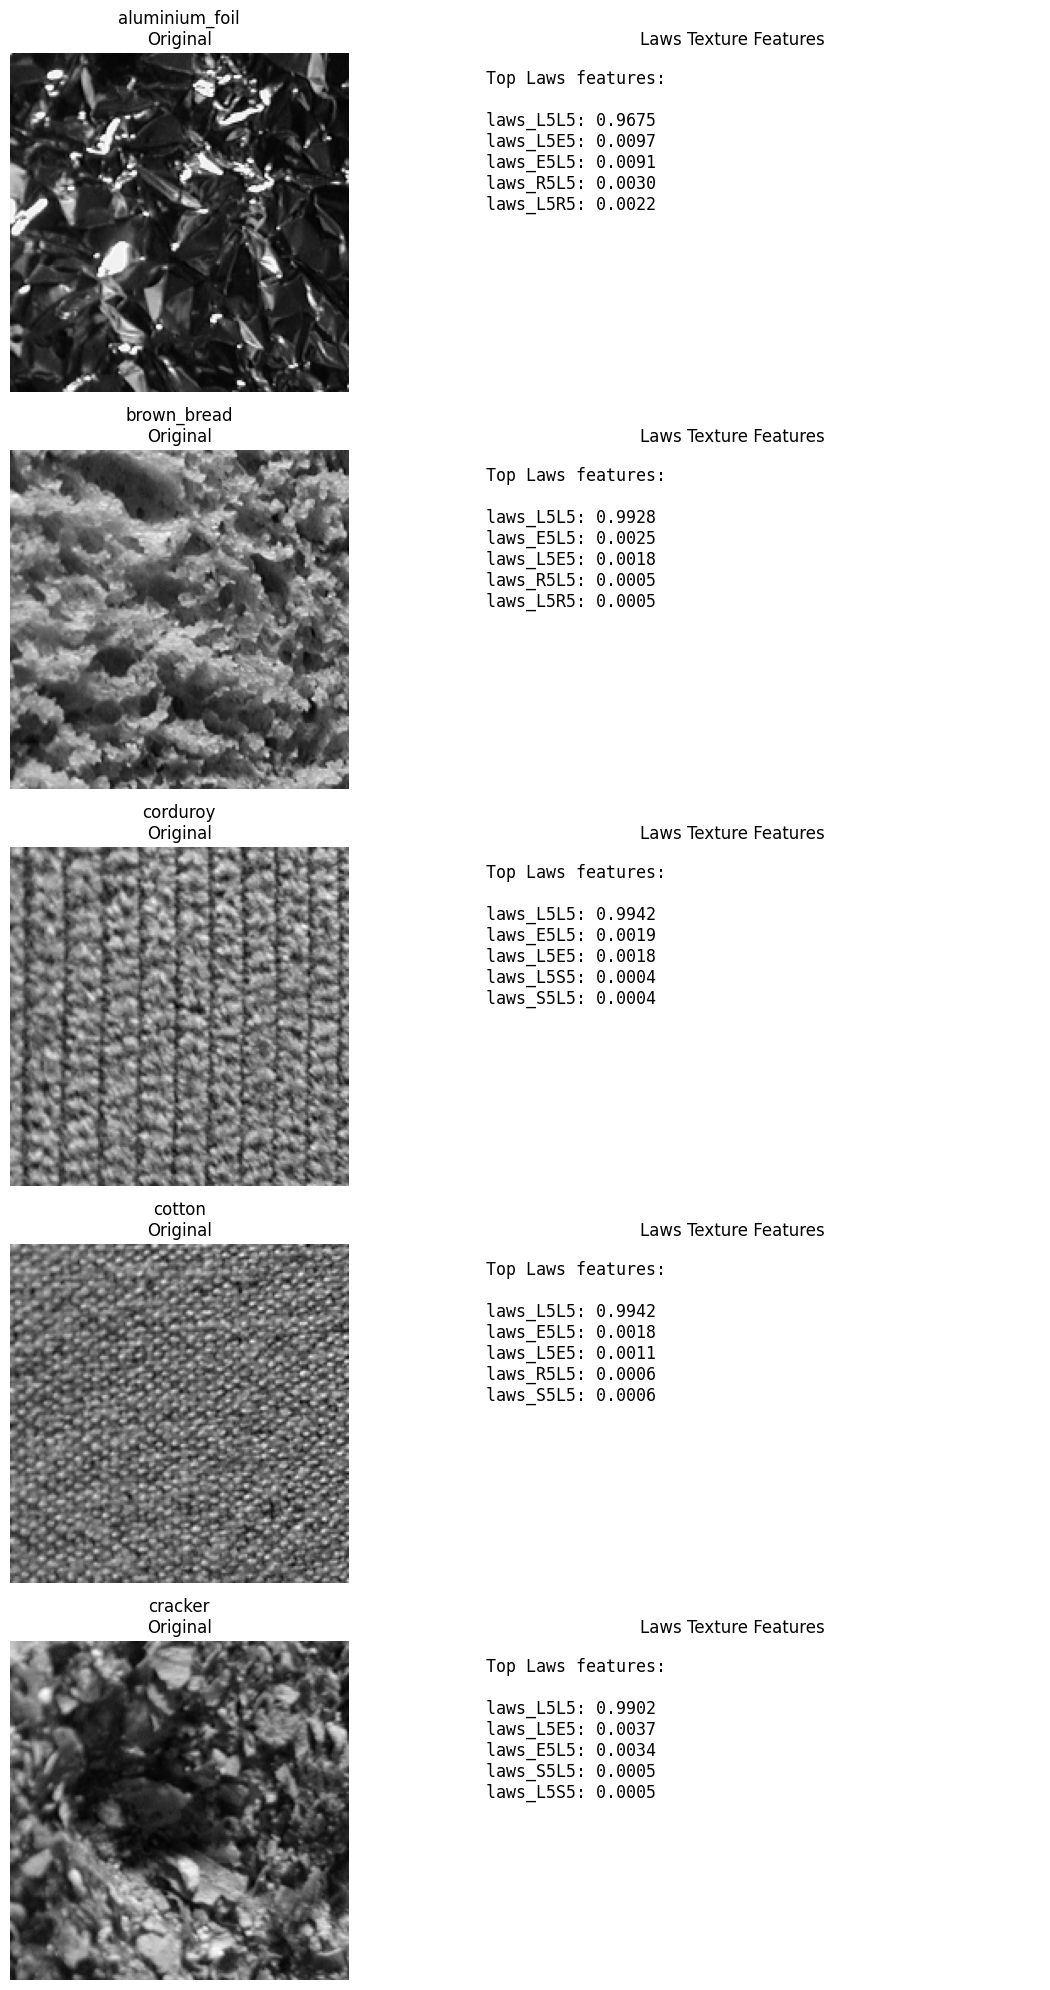

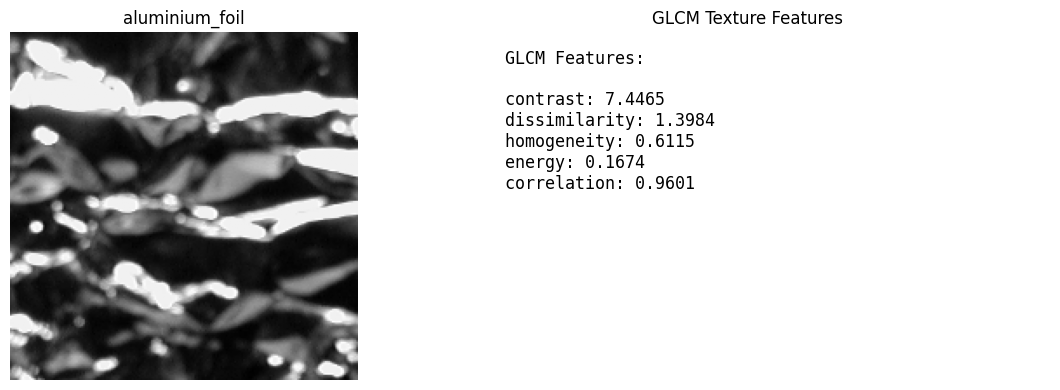

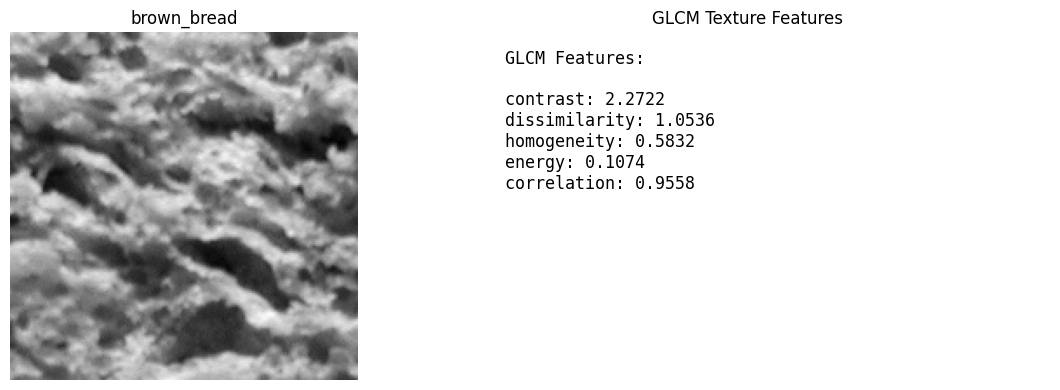

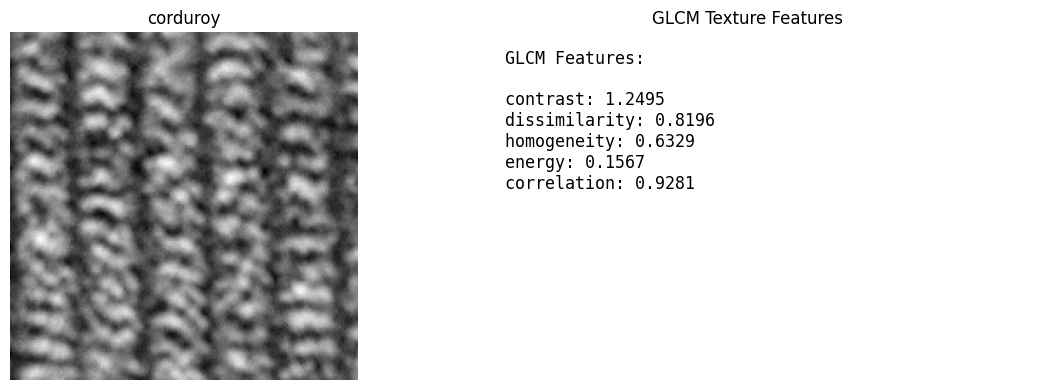

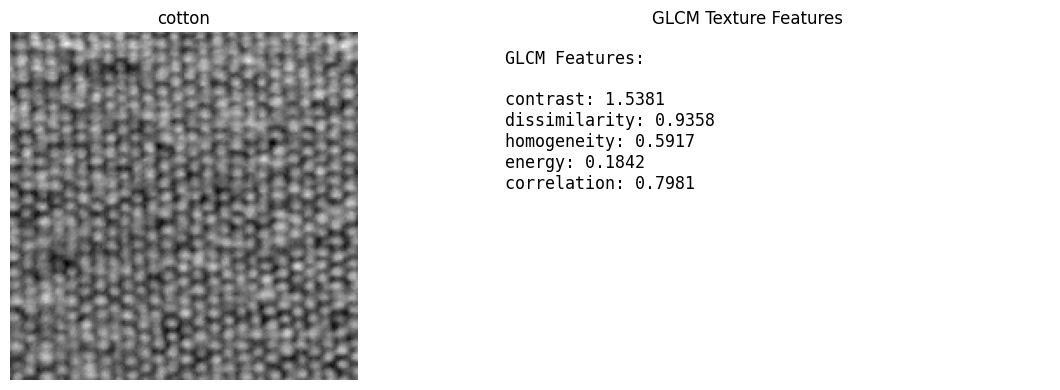

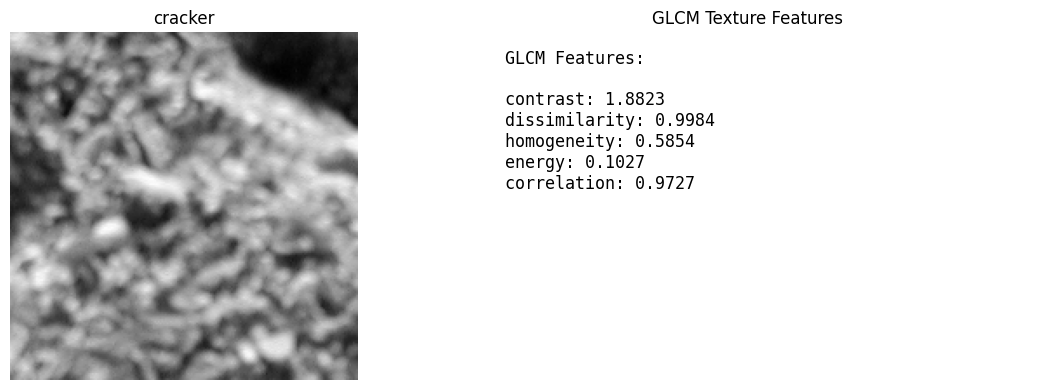

In [16]:
def load_texture_data_with_statistics(image_folder):
    data = []
    labels = []

    for texture_name in os.listdir(image_folder):
        texture_path = os.path.join(image_folder, texture_name)

        if os.path.isdir(texture_path):
            for image_file in os.listdir(texture_path):
                image_path = os.path.join(texture_path, image_file)

                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    features = compute_histogram_features(image)
                    data.append(features)
                    labels.append(texture_name)

    return np.array(data), np.array(labels)

def calculate_histogram_features(gray_image, bins=256):
    hist = cv2.calcHist([gray_image], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    hist = hist / hist.sum()

    values = np.arange(bins)
    features_dict = {}

    features_dict['mean'] = np.sum(hist * values)

    variance = np.sum(hist * (values - features_dict['mean'])**2)
    features_dict['std'] = np.sqrt(variance)

    if features_dict['std'] > 0:
        features_dict['skewness'] = np.sum(hist * ((values - features_dict['mean']) / features_dict['std'])**3)
    else:
        features_dict['skewness'] = 0

    if features_dict['std'] > 0:
        features_dict['kurtosis'] = np.sum(hist * ((values - features_dict['mean']) / features_dict['std'])**4) - 3
    else:
        features_dict['kurtosis'] = -3

    non_zero_probs = hist[hist > 0]
    features_dict['entropy'] = -np.sum(non_zero_probs * np.log2(non_zero_probs))

    cumulative_hist = np.cumsum(hist)
    features_dict['q1'] = np.argmax(cumulative_hist >= 0.25)
    features_dict['q2'] = np.argmax(cumulative_hist >= 0.5)
    features_dict['q3'] = np.argmax(cumulative_hist >= 0.75)

    non_zero_bins = np.where(hist > 0)[0]
    if len(non_zero_bins) > 0:
        features_dict['min'] = non_zero_bins[0]
        features_dict['max'] = non_zero_bins[-1]
    else:
        features_dict['min'] = 0
        features_dict['max'] = 255

    return features_dict, hist

def compute_histogram_features(gray_image, bins=256):
    hist = None
    stats_dict, hist = calculate_histogram_features(gray_image, bins)

    features = [
        stats_dict['mean'],
        stats_dict['std'],
        stats_dict['skewness'],
        stats_dict['kurtosis'],
        stats_dict['entropy'],
        stats_dict['q1'],
        stats_dict['q2'],
        stats_dict['q3'],
        stats_dict['min'],
        stats_dict['max']
    ]

    return np.array(features)

image_folder = "./KTH_TIPS"
data, labels = load_texture_data_with_statistics(image_folder)

print(f"Размер данных: {data.shape}")
print(f"Количество классов: {len(np.unique(labels))}")

def plot_texture_examples(image_folder, num_examples):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]

    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))

    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)

        image_files = [f for f in os.listdir(texture_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(image_files) > 3:
            image_path = os.path.join(texture_path, image_files[3])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                features, hist = calculate_histogram_features(image)

                axes[i, 0].imshow(image, cmap='gray')
                axes[i, 0].set_title(f'{texture_name}')
                axes[i, 0].axis('off')

                axes[i, 1].bar(range(256), hist, alpha=0.7, color='blue')
                axes[i, 1].set_title('Гистограмма')

                metrics_text = (
                    f"Mean: {features['mean']:.2f}\n"
                    f"Std: {features['std']:.2f}\n"
                    f"Skewness: {features['skewness']:.2f}\n"
                    f"Kurtosis: {features['kurtosis']:.2f}\n"
                    f"Entropy: {features['entropy']:.2f}\n"
                    f"Min/Max: {features['min']}/{features['max']}"
                )

                axes[i, 2].text(0.1, 0.9, metrics_text, transform=axes[i, 2].transAxes, fontsize=12, verticalalignment='top')
                axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

plot_texture_examples(image_folder, num_examples=5)

def extract_laws_texture_features(image, normalize=True):
    L5 = np.array([1,  4,  6,  4,  1])
    E5 = np.array([-1, -2,  0,  2,  1])
    S5 = np.array([-1,  0,  2,  0, -1])
    W5 = np.array([-1,  2,  0, -2,  1])
    R5 = np.array([1,  -4,  6, -4,  1])

    masks_1d = [L5, E5, S5, W5, R5]
    masks_names = ['L5', 'E5', 'S5', 'W5', 'R5']

    filters_2d = []
    filter_names = []

    for i, mask1 in enumerate(masks_1d):
        for j, mask2 in enumerate(masks_1d):
            kernel = np.outer(mask1, mask2)
            filters_2d.append(kernel)
            filter_names.append(f"{masks_names[i]}{masks_names[j]}")

    features = []
    feature_names = []

    for kernel, name in zip(filters_2d, filter_names):
        filtered = cv2.filter2D(image.astype(np.float32), -1, kernel)
        energy = np.mean(filtered ** 2)
        features.append(energy)
        feature_names.append(f"laws_{name}")

    features = np.array(features)

    if normalize and np.sum(features) > 0:
        features = features / np.sum(features)

    return features, feature_names

def plot_laws_examples(image_folder, num_examples):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]

    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4*num_examples))

    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)

        image_files = [f for f in os.listdir(texture_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(image_files) > 5:
            image_path = os.path.join(texture_path, image_files[5])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                features, names = extract_laws_texture_features(image)

                axes[i, 0].imshow(image, cmap='gray')
                axes[i, 0].set_title(f'{texture_name}\nOriginal')
                axes[i, 0].axis('off')

                top_indices = np.argsort(features)[-5:][::-1]
                laws_text = "Top Laws features:\n\n"
                for j, idx in enumerate(top_indices):
                    laws_text += f"{names[idx]}: {features[idx]:.4f}\n"

                axes[i, 1].text(0.1, 0.95, laws_text, transform=axes[i, 1].transAxes,
                                fontsize=12, verticalalignment='top', fontfamily='monospace')
                axes[i, 1].set_title('Laws Texture Features')
                axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

plot_laws_examples(image_folder, num_examples=5)

def compute_glcm_texture_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    image = (image // 8).astype(np.uint8)

    glcm = graycomatrix(image, distances=distances, angles=angles,
                       levels=32, symmetric=True, normed=True)

    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

    for prop in props:
        feature_val = np.mean(graycoprops(glcm, prop))
        features.append(feature_val)

    return np.array(features)

def plot_glcm_examples(image_folder, num_examples):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]

    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)

        image_files = [f for f in os.listdir(texture_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(image_files) > 2:
            image_path = os.path.join(texture_path, image_files[2])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                features = compute_glcm_texture_features(image)

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 2, 1)
                plt.imshow(image, cmap='gray')
                plt.title(f'{texture_name}')
                plt.axis('off')

                plt.subplot(1, 2, 2)

                glcm_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
                glcm_text = "GLCM Features:\n\n"
                for name, value in zip(glcm_names, features):
                    glcm_text += f"{name}: {value:.4f}\n"

                plt.text(0.1, 0.95, glcm_text, transform=plt.gca().transAxes,
                        fontsize=12, verticalalignment='top', fontfamily='monospace')
                plt.axis('off')
                plt.title('GLCM Texture Features')

                plt.tight_layout()
                plt.show()

plot_glcm_examples(image_folder, num_examples=5)

In [17]:
image_paths = []
for class_folder in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_folder)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, file))

print(f"Найдено {len(image_paths)} изображений")

X_hist = []
X_laws = []
X_glcm = []
y = []

for i, path in enumerate(image_paths):
    if i % 50 == 0:
        print(f"Обработано {i}/{len(image_paths)} изображений")

    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)

    # Используем новые названия методов
    hist_features    = compute_histogram_features(image)
    laws_features, _ = extract_laws_texture_features(image)
    glcm_features    = compute_glcm_texture_features(image)

    X_hist.append(hist_features)
    X_laws.append(laws_features)
    X_glcm.append(glcm_features)

    label = os.path.basename(os.path.dirname(path))
    y.append(label)

X_hist = np.array(X_hist)
X_laws = np.array(X_laws)
X_glcm = np.array(X_glcm)
y = np.array(y)

print(f"Размер данных гистограмм: {X_hist.shape}")
print(f"Размер данных Laws: {X_laws.shape}")
print(f"Размер данных GLCM: {X_glcm.shape}")
print(f"Количество классов: {len(np.unique(y))}")

le = LabelEncoder()
y_encoded = le.fit_transform(y)

methods = {
    'Histogram': X_hist,
    'Laws': X_laws,
    'GLCM': X_glcm
}

models = {
    'kNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    'SVM': SVC(kernel='rbf', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10)
}

Найдено 810 изображений
Обработано 0/810 изображений
Обработано 50/810 изображений
Обработано 100/810 изображений
Обработано 150/810 изображений
Обработано 200/810 изображений
Обработано 250/810 изображений
Обработано 300/810 изображений
Обработано 350/810 изображений
Обработано 400/810 изображений
Обработано 450/810 изображений
Обработано 500/810 изображений
Обработано 550/810 изображений
Обработано 600/810 изображений
Обработано 650/810 изображений
Обработано 700/810 изображений
Обработано 750/810 изображений
Обработано 800/810 изображений
Размер данных гистограмм: (810, 10)
Размер данных Laws: (810, 25)
Размер данных GLCM: (810, 5)
Количество классов: 10


In [18]:
trained_models = {}

for method_name, X in methods.items():
    print(f"\n{method_name.upper()}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    method_models = {}

    for model_name, model_template in models.items():
        if model_name == 'kNN':
            model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
        elif model_name == 'SVM':
            model = SVC(kernel='rbf', random_state=42)
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(random_state=42, max_depth=10)

        if model_name == 'SVM':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            method_models[model_name] = (model, scaler)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            method_models[model_name] = model

        print(f"{model_name}")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        print()

    trained_models[method_name] = method_models


HISTOGRAM
kNN
                precision    recall  f1-score   support

aluminium_foil       0.95      1.00      0.98        20
   brown_bread       0.90      0.95      0.93        20
      corduroy       0.58      0.70      0.64        20
        cotton       0.55      0.52      0.54        21
       cracker       0.83      0.71      0.77        21
         linen       0.76      0.65      0.70        20
   orange_peel       0.94      0.76      0.84        21
     sandpaper       0.39      0.35      0.37        20
        sponge       0.64      0.80      0.71        20
     styrofoam       0.91      1.00      0.95        20

      accuracy                           0.74       203
     macro avg       0.75      0.74      0.74       203
  weighted avg       0.75      0.74      0.74       203


SVM
                precision    recall  f1-score   support

aluminium_foil       0.95      1.00      0.98        20
   brown_bread       0.94      0.80      0.86        20
      corduroy       0.6

   Обрабатываем: Histogram_kNN
Уникальные классы после фильтрации: [0 1 2 3]
   Успешно
   Обрабатываем: Laws_Tree
Уникальные классы после фильтрации: [0 1 2 3]
   Успешно
   Обрабатываем: Laws_SVM
Уникальные классы после фильтрации: [0 1 2 3]
   Успешно


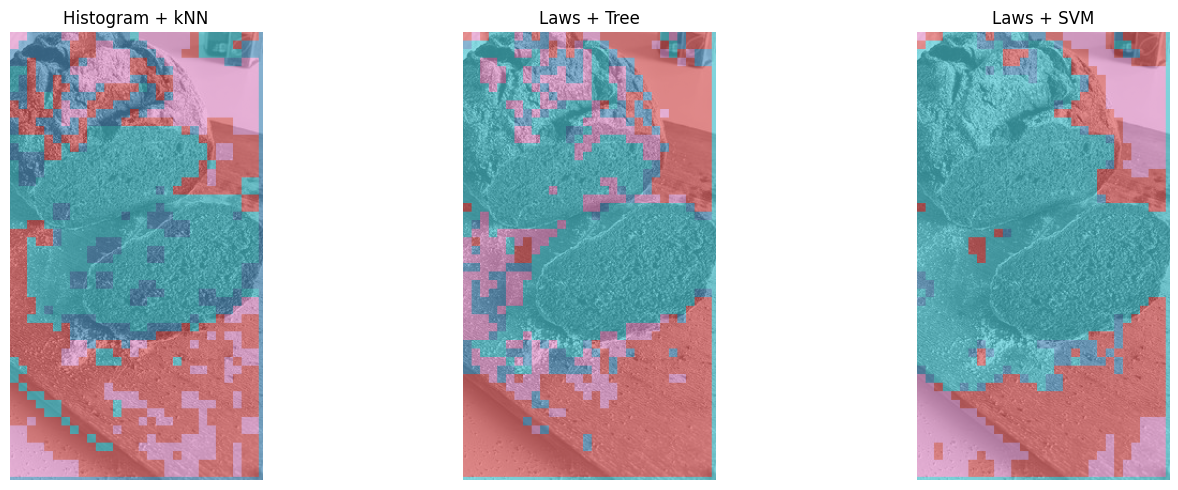


Обработано моделей: 3/3


In [19]:
selected_models = {
    'Histogram_kNN': trained_models['Histogram']['kNN'],
    'Laws_Tree': trained_models['Laws']['DecisionTree'],
    'Laws_SVM': trained_models['Laws']['SVM']
}

def segment_sandwich(model_info, model_name, image_path, patch_size=32, step=16, n_classes=4):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None

    h, w = image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)

    all_predictions = []
    positions = []

    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = image[y:y+patch_size, x:x+patch_size]

            if 'Histogram' in model_name:
                features = compute_histogram_features(patch)  # Изменено название
            elif 'Laws' in model_name:
                features, _ = extract_laws_texture_features(patch)  # Изменено название
            elif 'GLCM' in model_name:
                features = compute_glcm_texture_features(patch)  # Изменено название

            if isinstance(model_info, tuple):
                model, scaler = model_info
                features_scaled = scaler.transform(features.reshape(1, -1))
                pred_class = model.predict(features_scaled)[0]
            else:
                model = model_info
                pred_class = model.predict(features.reshape(1, -1))[0]

            seg_map[y:y+patch_size, x:x+patch_size] = pred_class
            all_predictions.append(pred_class)
            positions.append((y, x))

    unique, counts = np.unique(all_predictions, return_counts=True)

    top_classes = unique[np.argsort(counts)[-n_classes:]]

    seg_map_filtered = np.zeros_like(seg_map)

    for i, class_id in enumerate(top_classes):
        seg_map_filtered[seg_map == class_id] = i

    mask_not_in_top = ~np.isin(seg_map, top_classes)
    if np.any(mask_not_in_top):
        seg_map_filtered[mask_not_in_top] = 1

    print(f"Уникальные классы после фильтрации: {np.unique(seg_map_filtered)}")

    return seg_map_filtered

goal_image_path = "bread.jpg"
original_img = cv2.imread(goal_image_path, cv2.IMREAD_GRAYSCALE)

if original_img is not None:
    seg_maps = []
    model_names = []

    for model_name, model_info in selected_models.items():
        print(f"   Обрабатываем: {model_name}")

        seg_result = segment_sandwich(model_info, model_name, goal_image_path,
                                    patch_size=16, step=8)

        if seg_result is not None:
            seg_maps.append(seg_result)
            model_names.append(model_name)
            print(f"   Успешно")
        else:
            print(f"   Ошибка")

    if seg_maps:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for i, (seg_map, model_name) in enumerate(zip(seg_maps, model_names)):
            if 'Histogram' in model_name:
                method = 'Histogram'
                model_type = 'kNN'
            elif 'Laws' in model_name:
                method = 'Laws'
                model_type = 'Tree' if 'Tree' in model_name else 'SVM'

            axes[i].imshow(original_img, cmap='gray', alpha=0.7)
            axes[i].imshow(seg_map, cmap='tab10', alpha=0.5)
            axes[i].set_title(f'{method} + {model_type}', fontsize=12)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\nОбработано моделей: {len(seg_maps)}/3")
    else:
        print("Ни одна модель не вернула результат!")
else:
    print(f"Не удалось загрузить изображение: {goal_image_path}")

Топ-4 самых частых цветов: [ 25  50 134 132]
Их частоты: [44948 39949  6227  2325]


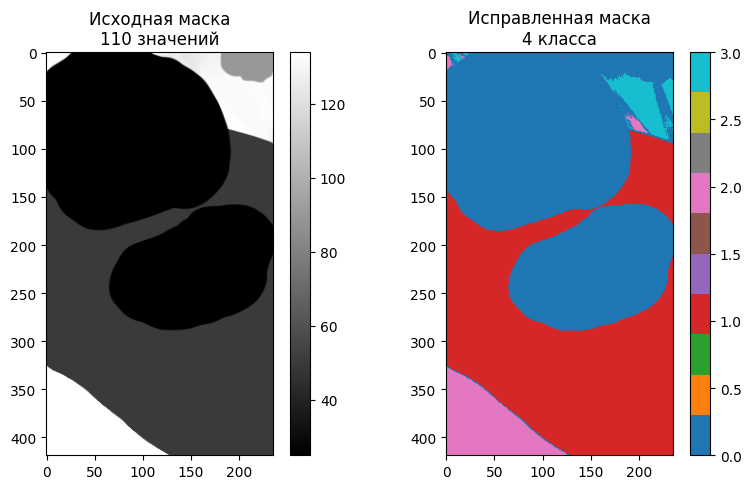

In [20]:
def keep_top_colors(mask, n_colors=4):
    unique, counts = np.unique(mask, return_counts=True)

    sorted_indices = np.argsort(-counts)
    top_colors = unique[sorted_indices[:n_colors]]  # берем n самых частых

    print(f"Топ-{n_colors} самых частых цветов: {top_colors}")
    print(f"Их частоты: {counts[sorted_indices[:n_colors]]}")

    result = np.zeros_like(mask)

    for new_value, old_value in enumerate(top_colors):
        result[mask == old_value] = new_value

    return result

# Путь к ручной маске
manual_mask_path = "bread_manual.png"
manual_mask = cv2.imread(manual_mask_path, cv2.IMREAD_GRAYSCALE)

if manual_mask is not None:
    fixed_manual_mask = keep_top_colors(manual_mask, n_colors=4)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(manual_mask, cmap='gray')
    plt.title(f'Исходная маска\n{len(np.unique(manual_mask))} значений')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(fixed_manual_mask, cmap='tab10')
    plt.title('Исправленная маска\n4 класса')
    plt.colorbar()

    plt.tight_layout()
    plt.show()
else:
    print(f"Не удалось загрузить ручную маску по пути: {manual_mask_path}")
    print("Проверьте путь и убедитесь, что файл '6my.png' существует в папке './goal/'")

Запускаем сегментацию...
Уникальные классы после фильтрации: [0 1 2 3]
Предсказание: (419, 236)
Уникальные классы в предсказании: [0 1 2 3]
Классы в ручной разметке: [0 1 2 3]
Классы в предсказании: [0 1 2 3]

Точность: 48.3%
IoU по классам:
   Класс 0: 0.494
   Класс 1: 0.003
   Класс 2: 0.114
   Класс 3: 0.000


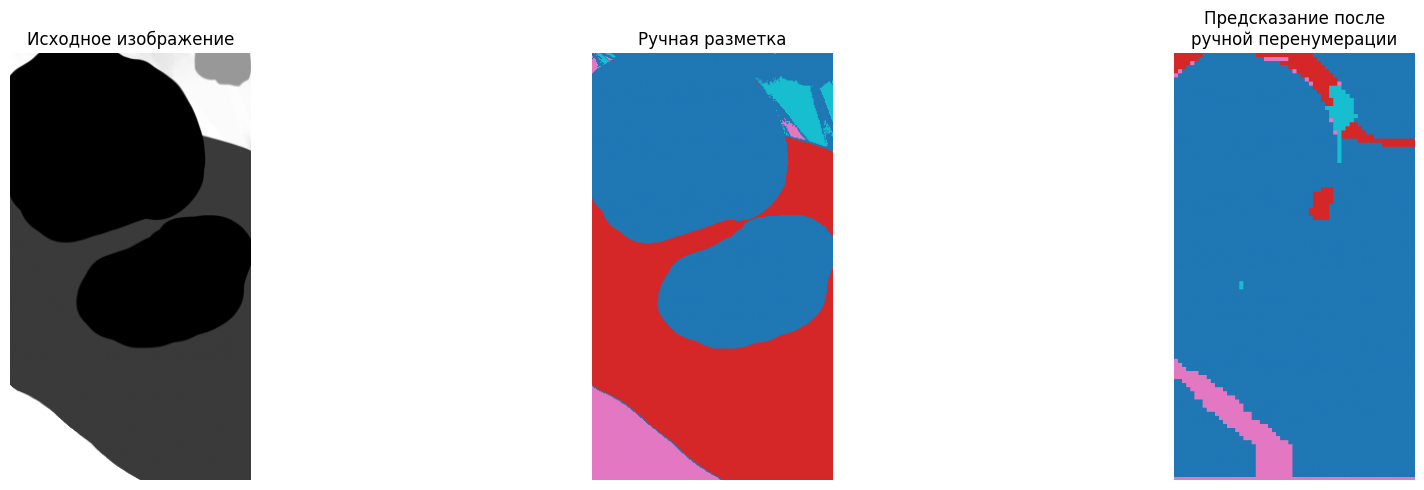

Итог: 48.3% правильных пикселей


In [21]:
def compare_simple(manual_mask, predicted_mask, model_name, original_img):

    predicted_resized = predicted_mask

    manual_classes = np.unique(manual_mask)
    pred_classes = np.unique(predicted_resized)

    print(f"Классы в ручной разметке: {manual_classes}")
    print(f"Классы в предсказании: {pred_classes}")

    class_mapping = {
        0: 3,
        1: 2,
        2: 1,
        3: 0
    }

    pred_mapped = predicted_resized.copy()
    for pred_class, manual_class in class_mapping.items():
        pred_mapped[predicted_resized == pred_class] = manual_class

    accuracy = accuracy_score(manual_mask.flatten(), pred_mapped.flatten())

    print(f"\nТочность: {accuracy:.1%}")
    print(f"IoU по классам:")

    for class_id in manual_classes:
        iou = jaccard_score(manual_mask.flatten(), pred_mapped.flatten(),
                          average=None, labels=[class_id])[0]
        print(f"   Класс {class_id}: {iou:.3f}")

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')

    axes[1].imshow(manual_mask, cmap='tab10')
    axes[1].set_title('Ручная разметка')
    axes[1].axis('off')

    axes[2].imshow(pred_mapped, cmap='tab10')
    axes[2].set_title(f'Предсказание после\nручной перенумерации')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return accuracy

goal_image_path = "bread_manual.png"
original_img = cv2.imread(goal_image_path, cv2.IMREAD_GRAYSCALE)

model_name = 'Laws_SVM'
model_info = selected_models[model_name]

print("Запускаем сегментацию...")
predicted_mask = segment_sandwich(
    model_info, model_name, goal_image_path,
    patch_size=32, step=4
)

print(f"Предсказание: {predicted_mask.shape}")
print(f"Уникальные классы в предсказании: {np.unique(predicted_mask)}")

if fixed_manual_mask is not None and predicted_mask is not None and original_img is not None:
    accuracy = compare_simple(fixed_manual_mask, predicted_mask, model_name, original_img)
    print(f"Итог: {accuracy*100:.1f}% правильных пикселей")